In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Dueling_DQN_Agent.Dueling_DQN_Agent import Dueling_DQN_Agent#
from Combined_Agent.Dueling_DQN_Agent import Dueling_DQN_Agent as Combined_Agent
import Dueling_DQN_Agent.utils.help_classes as hc
import Dueling_DQN_Agent.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(30)]

seed = SEED_TRAIN_1

In [4]:
reload(h_env)
env_name = "Combined_test_1_50k_30k_(128,128)"
env = h_env.HockeyEnv()

state_space = env.observation_space
action_space = env.discrete_action_space

agent = Dueling_DQN_Agent(state_space, action_space, seed = seed, use_eps_decay = True, hidden_sizes = [128, 128]) 
opponent = h_env.BasicOpponent()
agent.Q.load(env_name)
stats, losses = sf.load_stats(env_name)

Network loaded from Hockey_200000_30000_(128_128)/weights/training_finished.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Plot saved at Hockey_200000_30000_(128_128)/stats/plots/returns_plot.png


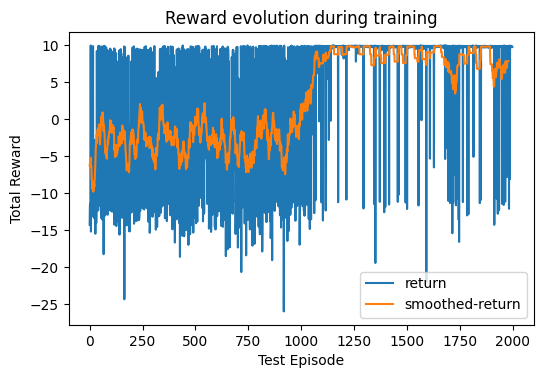

In [5]:
sf.plot_returns(stats, env_name)

Plot saved at Hockey_200000_30000_(128_128)/stats/plots/losses_plot.png


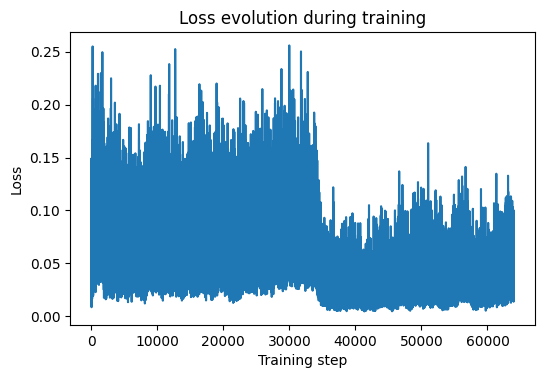

In [6]:
sf.plot_losses(losses, env_name)

Test Episode 1, Total Reward: 9.128288398395298
Test Episode 2, Total Reward: 9.837328601400221
Test Episode 3, Total Reward: 9.419051761776517
Test Episode 4, Total Reward: 9.792010571526523
Test Episode 5, Total Reward: -10.015572631385838
Test Episode 6, Total Reward: 9.892501637515219
Test Episode 7, Total Reward: -15.99540834123616
Test Episode 8, Total Reward: 7.412752017594578
Test Episode 9, Total Reward: 9.544266319210774
Test Episode 10, Total Reward: 9.75936431923943
Test Episode 11, Total Reward: -23.387679183167112
Test Episode 12, Total Reward: 9.862906497864318
Test Episode 13, Total Reward: 8.511645118404498
Test Episode 14, Total Reward: -11.927303706514806
Test Episode 15, Total Reward: 9.577627971774595
Test Episode 16, Total Reward: 9.83818753626002
Test Episode 17, Total Reward: 9.466263896137665
Test Episode 18, Total Reward: 9.874157885070387
Test Episode 19, Total Reward: -17.904080488786374
Test Episode 20, Total Reward: -11.104208590181305
Test Episode 21, Tot

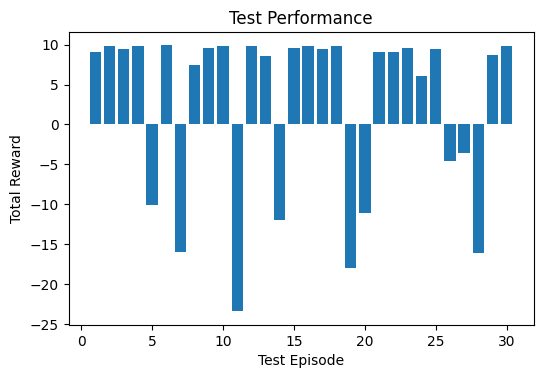

In [8]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

opponent = h_env.BasicOpponent()

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)
        full_action = np.hstack([env.discrete_to_continous_action(a1), a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        agent.buffer.add_transition((state, a1, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)